# Imports + Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

plt.rcParams.update({'figure.figsize':(11,7), 'figure.dpi':120})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']
datapath = '../Data/'

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'

# Load Predictions

In [2]:
filename = 'log_predictions.pickle'
infile = open(datapath+filename,'rb')
log_predictions = pickle.load(infile)
infile.close()

print(len(log_predictions))

log_predictions.head()

84345


,SPA_PER_ID,prediction,CMIS_MATCH
0,3,0.002089,False
1,4,0.001236,False
2,6,0.002334,False
3,12,0.001311,False
4,14,0.001866,False


In [3]:
'''
filename = 'ann_predictions.pickle'
infile = open(datapath+filename,'rb')
ann_predictions = pickle.load(infile)
infile.close()

print(len(ann_predictions))

print(ann_predictions['CMIS_MATCH'].sum())

ann_predictions.head()
'''

"\nfilename = 'ann_predictions.pickle'\ninfile = open(datapath+filename,'rb')\nann_predictions = pickle.load(infile)\ninfile.close()\n\nprint(len(ann_predictions))\n\nprint(ann_predictions['CMIS_MATCH'].sum())\n\nann_predictions.head()\n"

# ROC Curve

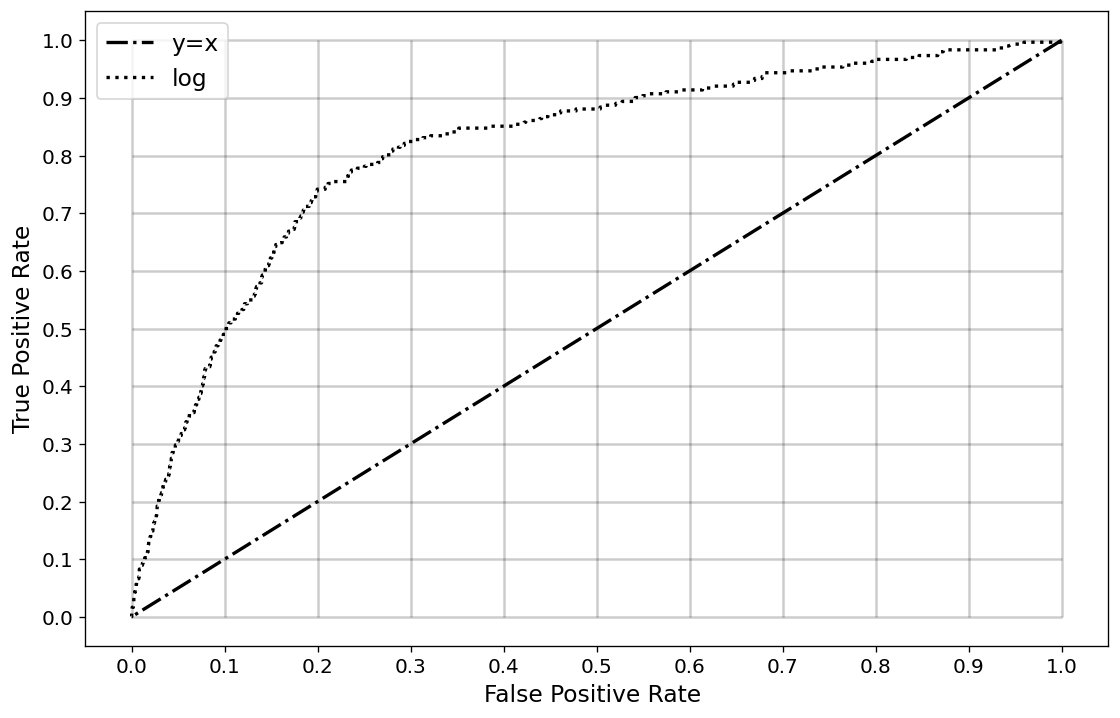

In [4]:
linewidth = 2
color = 'black'
alpha=0.2

# Refernce line
plt.plot([1,0], [1,0], color='black', label='y=x', linestyle='dashdot', linewidth=linewidth)

# Log
fpr, tpr, _ = roc_curve(y_true=log_predictions[event_col].astype('bool'), y_score=log_predictions['prediction'])
plt.plot(fpr, tpr, color='black', label='log', linestyle='dotted', linewidth=linewidth)

# Linearly weighted predictions
#fpr, tpr, _ = roc_curve(y_true=log_weighted_predictions[event_col].astype('bool'), y_score=log_weighted_predictions['linear'])
#plt.plot(fpr, tpr, color='red', label='log_linear', linestyle='dotted', linewidth=linewidth)

# Exponentially weighted predictions
#fpr, tpr, _ = roc_curve(y_true=log_weighted_predictions[event_col].astype('bool'), y_score=log_weighted_predictions['exp'])
#plt.plot(fpr, tpr, color='red', label='log_linear', linestyle='dotted', linewidth=linewidth)

# ANN predictions
#fpr, tpr, _ = roc_curve(y_true=ann_predictions[event_col].astype('bool'), y_score=ann_predictions['prediction'])
#plt.plot(fpr, tpr, color='red', label='ann', linestyle='dotted', linewidth=linewidth)


ticks = np.arange(0,1.1,0.1)
plt.hlines(y=ticks, xmin=0, xmax=1, colors=color, alpha=alpha)
plt.vlines(x=ticks, ymin=0, ymax=1, colors=color, alpha=alpha)
plt.xlabel('False Positive Rate ', fontsize=fontsize)
plt.xticks(ticks, fontsize=fontsize-2)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.yticks(ticks, fontsize=fontsize-2)
plt.legend(fontsize=fontsize)
# plt.savefig(fname=image_dest+'ROC.png', bbox_inches='tight')
plt.show()

# Get Certain Points

In [5]:
def get_point_at_fpr(target:float, fpr, tpr):
    for i in range(len(fpr)):
        if fpr[i] > target:
            return fpr[i], tpr[i]

def get_points(targets, fpr, tpr):
    columns = ['FPR', 'TPR']
    output = np.zeros(shape=(len(targets), 2))
    for i in range(len(targets)):
        output[i] = get_point_at_fpr(target=targets[i], fpr=fpr, tpr=tpr)
    return pd.DataFrame(output, columns=columns)

In [6]:
points = get_points([0.05, 0.1, 0.15, 0.2, 0.3, 0.63, 0.8], fpr=fpr, tpr=tpr) * 100
points.transpose()

,0,1,2,3,4,5,6
FPR,5.046226,10.071035,15.075616,20.815535,30.222624,63.021311,80.011423
TPR,30.463576,49.006623,62.251656,74.172185,82.450331,92.052980,96.688742


In [7]:
print(points.transpose().to_latex(index=True, float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &     0 &     1 &     2 &     3 &     4 &     5 &     6 \\
\midrule
FPR &  5.05 & 10.07 & 15.08 & 20.82 & 30.22 & 63.02 & 80.01 \\
TPR & 30.46 & 49.01 & 62.25 & 74.17 & 82.45 & 92.05 & 96.69 \\
\bottomrule
\end{tabular}



In [8]:
get_points([.63], fpr=fpr, tpr=tpr)

,FPR,TPR
0,0.630213,0.92053


In [22]:
len(log_predictions)

84345

In [19]:
num_pos = log_predictions['CMIS_MATCH'].sum()
num_neg = len(log_predictions) - num_pos

def rates_to_predicted_hits(tpr, fpr, p, n):
    total = p + n
    tp = int(round(tpr * p, 0))
    fp = int(round(fpr * n, 0))
    p_predicted = tp + fp
    
    n_predicted = total - tp - fp
    fn = p - tp
    tn = n_predicted - fn
    tnr = tn / n
    
    p_precision = tp / (tp + fp)
    n_precision = tn / (tn + fn)
    
    p_f1 = 2 * p_precision * tpr / (p_precision + tpr)
    n_f1 = 2 * n_precision * tnr / (n_precision + tnr)
    
    columns = ['Class', 'Actual', 'Predicted', 'Hits', 'TPR (TNR)', 'Precision', 'f-1']
    output = pd.DataFrame(columns=columns)
    
    output = output.append(
        pd.Series(data=dict(zip(columns, ['Positive', p, p_predicted, tp, tpr, p_precision, p_f1]))), 
        ignore_index=True
    )
    output = output.append(
        pd.Series(data=dict(zip(columns, ['Negative', n, n_predicted, tn, tnr, n_precision, n_f1]))), 
        ignore_index=True
    )
    return output
 
table = rates_to_predicted_hits(tpr=0.92053, fpr=0.630213, p=num_pos, n=num_neg)
table

,Class,Actual,Predicted,Hits,TPR (TNR),Precision,f-1
0,Positive,302,53243,278,0.920530,0.005221,0.010384
1,Negative,84043,31102,31078,0.369787,0.999228,0.539806


In [25]:
print(table.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllrrr}
\toprule
   Class & Actual & Predicted &  Hits &  TPR (TNR) &  Precision &  f-1 \\
\midrule
Positive &    302 &     53243 &   278 &       0.92 &       0.01 & 0.01 \\
Negative &  84043 &     31102 & 31078 &       0.37 &       1.00 & 0.54 \\
\bottomrule
\end{tabular}

